# Meteograma

En este ejemplo discribimos como hacer una figura que muestre la evolución de la temperatura a 2 m y la precipitación horaria en todos los plazos de pronóstico para una latitud y longitud determinada.<br />
*In this example we describe how to plot the hourly evolution of 2-m temperature and precipitation for a given place.*

In [2]:
# Importamos las librerías necesarias
# We import the necessary libraries
import xarray as xr
import h5netcdf
import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Definimos la fecha de inicialización del pronóstico y la latitud y longitud a consultar:<br />
*We define the forecast initialization date, latitude and longitude of interest:*

In [4]:
init_year = 2022
init_month = 4
init_day = 1
init_hour = 0
INIT_DATE = datetime.datetime(init_year, init_month, init_day, init_hour)

latitude = -40
longitude = -50

Leemos los pronósticos: <br />
*We read the forecast:*

In [ ]:

# Opción 1: Para acceder a los archivos online
# Option 1: To access files online
#import s3fs
#fs = s3fs.S3FileSystem(anon=True)

#files = fs.glob(f'smn-ar-wrf/DATA/WRF/DET/{START_DATE:%Y/%m/%d/%H}/WRFDETAR_01H_{START_DATE:%Y%m%d_%H}_*.nc')

#ds_list = []
#for s3_file in files:
#    print(s3_file)
#    f = fs.open(s3_file)
#    ds_tmp = xr.open_dataset(f, decode_coords = 'all', engine = 'h5netcdf')
#    ds_list.append(ds_tmp)

# Opción 2: Para abrir los archivos ya descargados
# Option 2: To open the already downloaded files
files = ['WRFDETAR_01H_{:%Y%m%d_%H}_{:03d}.nc'.format(INIT_DATE,lead_time) for lead_time in range(0, 73)]
ds_list = []
for file in files:
    print(file)
    ds_tmp = xr.open_dataset(file, decode_coords = 'all', engine = 'h5netcdf')
    ds_list.append(ds_tmp)

ds = xr.combine_by_coords(ds_list, combine_attrs = 'drop_conflicts')


Obtenemos los valores pronosticados en el punto seleccionado:<br />
*We get the appropriate forecast value:*

In [ ]:
# Buscamos la ubicación del punto más cercano a la latitud y longitud solicitada
# We search the closest gridpoint to the selected lat-lon 
data_crs = ccrs.LambertConformal(central_longitude = ds.CEN_LON, 
                                 central_latitude = ds.CEN_LAT, 
                                 standard_parallels = (ds.TRUELAT1, ds.TRUELAT2))
x, y = data_crs.transform_point(longitude, latitude, src_crs=ccrs.PlateCarree())

# Seleccionamos el dato más cercano a la latitud y longitud
# We extract the value at the chosen gridpoint
forecast = ds.sel(dict(x = x, y = y), method = 'nearest')

# Obtenemos la serie de temperatura a 2 m, precipitación acumulada y de fechas
# We get of time series for the 2-m temperature, accumulated precipitation and dates
T2 = forecast['T2']
PP = forecast['PP']
dates = forecast['time'].values


Realizamos la figura:<br /> 
*We create the plot:*

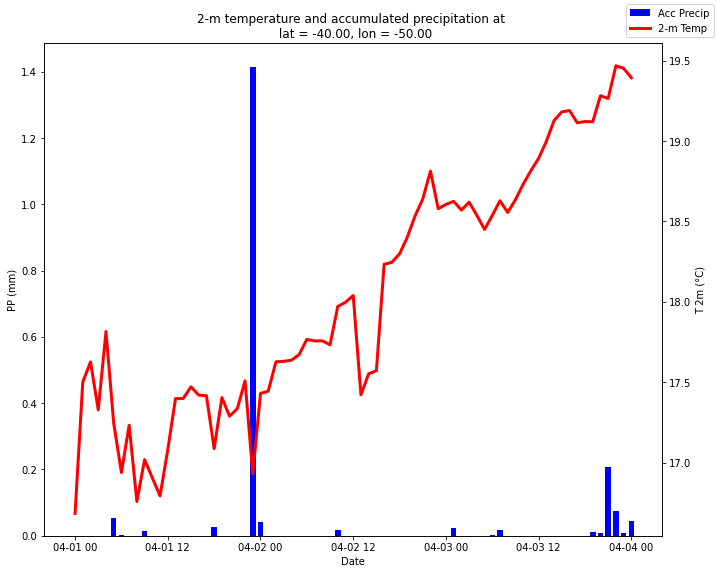

In [12]:
# Iniciamos de la figura
# We generate the plot
fig, ax = plt.subplots(figsize = (10, 8))
# Duplicamos el eje x
# We double x axis
ax2 = ax.twinx()
# Graficamos la precipitación en barras
# We choose bar diagram for precipitation 
ax.bar(dates, PP, color = 'blue', width = 0.03, label = 'Acc Precip')
# Graficamos la temperatura con una línea
# We choose simple lines for temperature
ax2.plot(dates, T2, color = 'red', label = '2-m Temp', linewidth = 3)
# Definimos las etiquetas de los ejes
# We define the labels in the axes 
ax.set_xlabel('Date')
ax2.set_ylabel('T 2m (°C)')
ax.set_ylabel('PP (mm)')
# Definimos el título de la figura
# We define the title of figure
plt.title(f'2-m temperature and accumulated precipitation at \n lat = {latitude:0.2f}, lon = {longitude:0.2f}')
# Graficamos la leyenda
# We locate color legend in the upper right corner 
fig.legend(loc = 'upper right')
# Ajustamos el gráfico al tamaño de la figura
# We adjuste graphic size
plt.tight_layout()